Notebook 4, Module 2, Statistical Inference for Data Science, CAS Applied Data Science, 2019-08-29, G. Conti, S. Haug, University of Bern.

## 3. Hypothesis Testing

Practice various tests with the Python scipy stats module.

**Average expected study time :** 3x45 min (depending on your background)

**Learning outcomes :**

- Know the hypothesis test vocabulary
- Can calculate p-values on different p.d.f's
- Can perform normality tests of samples
    - D'Agostino-Pearson test (Shapiro-Wilk, Kolmogorov-Smirnow) 
- Can perform t-Test on a single sample (testing against a given mean, gaussian)
- Can perform a Wilcoxon on a single sample (testing against a given median, not gaussian, only symmetric assumption)
- Can comparing two groups of data, e.g. treated and control, know which tests are suited for which cases
- Can perform some ANOVA tests

**Bonus skills**
- More Python tricks
- Get to know the Python stats module better: https://docs.scipy.org/doc/scipy/reference/stats.html

**Literature examples**

- https://en.wikipedia.org/wiki/Statistical_hypothesis_testing
- http://greenteapress.com/wp/think-stats-2e/ (online book covering most of the CAS Module 2)

- For life sciences (bioinformatics) for example
https://cran.r-project.org/doc/contrib/Krijnen-IntroBioInfStatistics.pdf
- (Particle) Physics
http://pdg.lbl.gov/2018/reviews/rpp2018-rev-statistics.pdf
- Finance, Insurance: For instance
Erik Boelvik, Computation and Modelling in Insurance and Finance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

## 3.1 Vocabulary and an example

The hypothesis being tested is called the Null hypothesis. When doing a statistical test, the test statistic of a sample is calculated and the p-value of this, under the null hypothesis assumption is given.

This p-value is the probability of obtaining such a sample if the null hypothesis is true. A significance level of 5% is often used as the threshold where you say, this is so unlikely that I consider the null hypothesis as wrong. However, 5% is not very significant (5 times of 100 this should actually happen).

**Example (not real)**

- Based on samples from previous years, the female/(male+female) ratio in a class is 0.6 (60%). This is a mean calculated counting heads in a class of 100 people. We counted 60 female students. So we can safely assume that the ratio is normally distributed with a standard deviation equal to the square root of 60. 

- Our (a bit stupid null hypotesis) is that the ratio stays constant for the next 10 years.

- This year we count 70 females in a class of 100. What is the p-value ? 

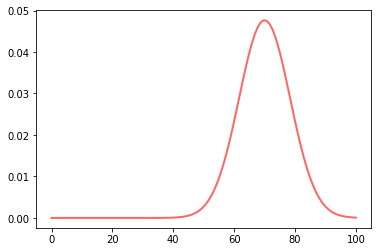

0.884001138185633


In [2]:
def get_pvalue_on_gauss(mu,data,nbins):
  sigma = np.sqrt(mu) # Standard deviation
  #print('The standard deviation is',sigma)
  # Plot the null hypothesis
  x = np.linspace(0,nbins, nbins) # 100 bins 
  plt.plot(x, stats.norm.pdf(x,mu,sigma),'r-', lw=2, alpha=0.6, label='norm pdf')
  plt.show()
  p_value = 1 - stats.norm.cdf(data,mu,sigma) # cdf = cumulated density function, see below
  #print('The p-value = %1.3f'% p_value) 
  return p_value

p_value = get_pvalue_on_gauss(70,60,100)
print(p_value)

Do you still think our null hypothesis is valid ?

1 - CDF is the p-value. If you want to know more about CDF, read this: https://en.wikipedia.org/wiki/Cumulative_distribution_function

**The same calculation with a Poisson distribution**


0.8733315069807178


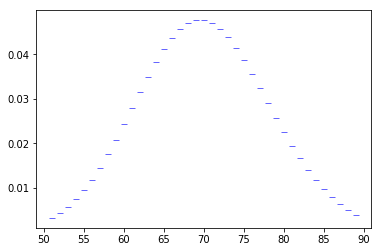

In [3]:
def get_pvalue_on_poisson(mu,data,nbins):
    p_value = 1 - stats.poisson.cdf(data,mu) 
    #print('The p-value = %1.3f'% p_value) 
    xp = np.arange(stats.poisson.ppf(0.01, mu), stats.poisson.ppf(0.99, mu))
    plt.plot(xp, stats.poisson.pmf(xp,mu),'b_', lw=2, alpha=0.6, label='poisson pdf')
    #plt.show()
    return p_value

p_value = get_pvalue_on_poisson(70,60,100)
print(p_value)

**p-value differences between Normal and Poisson**

How much does the p-value on the normal distribution (approximation) from the one on the Poisson distribution (supposed to be the correct):

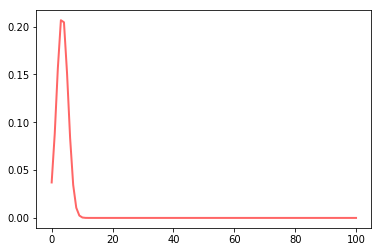

mu = 3.00 0.61 0.46


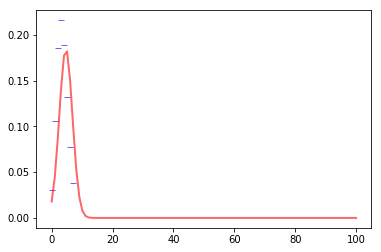

mu = 4.00 0.62 0.50


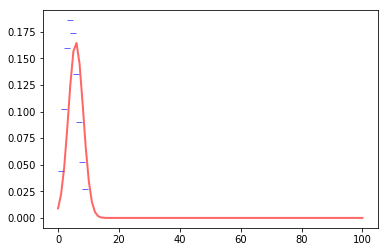

mu = 5.00 0.63 0.53


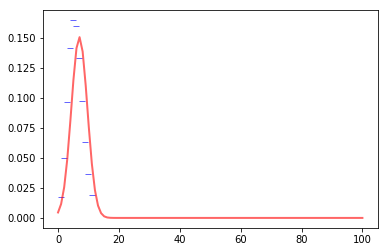

mu = 6.00 0.65 0.55


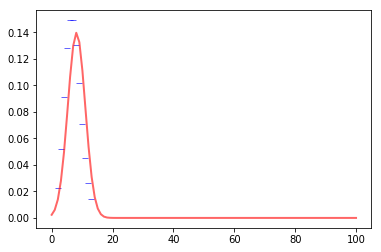

mu = 7.00 0.66 0.57


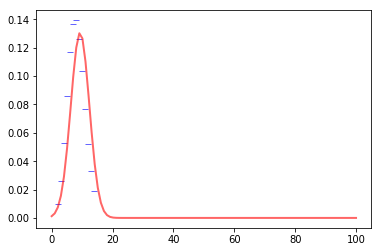

mu = 8.00 0.67 0.59


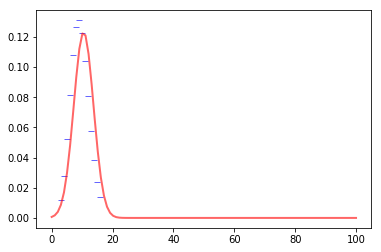

mu = 9.00 0.68 0.60


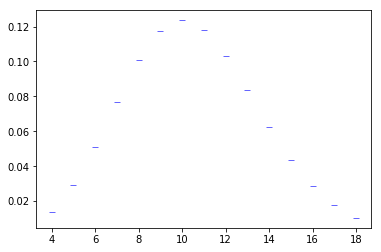

In [25]:
data_scale=70/60.
#for mu in range(3,100):
for mu in range(3,10):    
    pv_gauss=get_pvalue_on_gauss(data_scale*mu,mu,100)
    pv_poisson=get_pvalue_on_poisson(data_scale*mu,mu,100)
    print('mu = %1.2f %1.2f %1.2f' % (mu,pv_gauss,pv_poisson))

So we see that in our case (mu = 60), the p-value on the normal distribution is only one percent higher than on the poisson distribution. Conclusion: We can safely use the normal distribution as an approximation.

### Error types and statistical power

- Type I : Reject the null hypothesis due to a fluctuation (false positive)
- Type II : Keep the null hypothesis by interpreting a real effect as a fluctuation (false negative)
- (Type 0 : Make the right conclusion but asking the wrong question)
 
People may talk about the **statistical power** of their experiment. This is a number between 0 and 1 telling how often your experiment would lead to a type II error. So a high power (close to 1) means rare type II errors. The statistical power is infuenced by your significance criterion, the (physical) magnitude of your effect, the sample size ("statistics").

### Many tests

There are many tests on the market and some or most of them are implemented in Python (or R). We don't look at them all. We just practise on a few useful cases. You would look up suiteable tests for your analysis. The important thing is to know what a test assumes (distribution etc) and how to interprete the result and if you can trust the result


## 4.2 Normality tests of single samples


Normality tests can be performed for each column of data. Each normality test reports a p-value that answers this question:

If you randomly sample from a Gaussian population, what is the probability of obtaining a sample that deviates from a Gaussian distribution as much (or more so) as this sample does?

Normality tests are not good for small samples (<10-20 values). You can do it, but the interpration of the output is not straight forward.

There are several normality tests in the Python stats module:
- D’Agostino-Pearson
- Shapiro-Wilk
- Kolomogorv-Smirnov

The first one is considered the best one, so use that.

https://docs.scipy.org/doc/scipy/reference/stats.html


Let us look at the p-values of some normality tests with generated data.

In [5]:
pts = 1000
np.random.seed(28041990) # By fixing the seed, you can make the generation reproducible
# Generate two data samples a and b, each with 1000 entries
a = np.random.normal(0, 1, size=pts) # mean = 0, width = 1 (std deviation)
b = np.random.normal(2, 1, size=pts)
#x = np.concatenate((a, b))
x = a
k2, p = stats.normaltest(x) # D Agostino-Pearson. The method returns the test statistic value and the p-value
alpha = 0.001 # Rejection criterion defined by you
print('Alpha = ',alpha)
print('p = ',p)
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
  print("The null hypothesis cannot be rejected")

Alpha =  0.001
p =  0.12660904659553507
The null hypothesis cannot be rejected


This is not very surprising as we generated the data from a normal distribution.

Load the iris sepal length of species and get some descriptive values.

In [6]:
import pandas as pd
dataframe = pd.read_csv('iris.csv',names=['slength','swidth','plength','pwidth','name'])
df_setosa=dataframe[dataframe['name'] == 'Iris-setosa']
dfs = df_setosa['swidth']
print(stats.describe(dfs)) # Print some descriptive statistics
dfs.describe() # the pandas describe prints similar statistics

DescribeResult(nobs=50, minmax=(2.3, 4.4), mean=3.418, variance=0.1451795918367347, skewness=0.1038140820747848, kurtosis=0.6851340609499261)


count    50.000000
mean      3.418000
std       0.381024
min       2.300000
25%       3.125000
50%       3.400000
75%       3.675000
max       4.400000
Name: swidth, dtype: float64

Check the normality of the iris sepal length of species

In [7]:
k2, p = stats.normaltest(dfs) # D Agostino-Pearson test
print("p-value = %1.2f" % p)

p-value = 0.39


What does this p-value mean? If you want to know what the k2 is, look it up in the documentation.

We can also try the shapiro test that the stat module offers:

In [8]:
s,p = stats.shapiro(dfs)
print('Test statistic = ',s,' p-value =',p)

Test statistic =  0.968691885471344  p-value = 0.20465604960918427


In this case the shapiro test returns a much lower p-value. What can you do about this difference?

### t-Test (with a given mean)

With the t-test you can test your data against a normal distribution with a given mean:

If the data were sampled from a Gaussian population with a mean equal to the hypothetical value you entered, what is the chance of randomly selecting N data points and finding a mean as far (or further) from the hypothetical value as observed here?

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest

In [9]:
print('The sample mean of the sepal length = ',dfs.mean())
stats.ttest_1samp(dfs,3.3)

The sample mean of the sepal length =  3.418


Ttest_1sampResult(statistic=2.1898492754769694, pvalue=0.033325644557196644)

**Interpretation:** If the real average of the sepal length of setosa leaves is 3.3 cm and if the length of the leaves is normally distributed, the probability of sampling this data or worse data from setosa leaves is 3.3%. 

Our null hypothesis in this case was a normal distribution with mean equal to 3.3 cm.

## 4.3 Non-parametric Wilcoxon signed rank test

This test answers the same question as the t-test above, but is not testing against a normal distribution. It only assumes a symmetric shape. So there is normal assumption and no parameters involved. If you like, you can make an example yourself.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon

## 4.4 Tests for comparing two samples 

In many experiments one uses two groups, a treated group and a control group which is not treated. The goal is then to ckeck the effect of the treatment.

One way to answer this, is to check how much the treated group differs from the control group. Python stats module offer several tests to do this.

If the data is "paired", this can be used in the tests (they get better because there is more "information or structure" in the data). So we need to know what paired data is in order to choose the right test.

**Paired/related data**
- Repeated measurements on the same object/individual, e.g. before and after treatment 

**Unpaired/independent data**
- Independent, e.g. from separate individuals

We don't practise all tests (too much for one day).

**WHICH TEST TO CHOOSE - THE DIAGRAM**

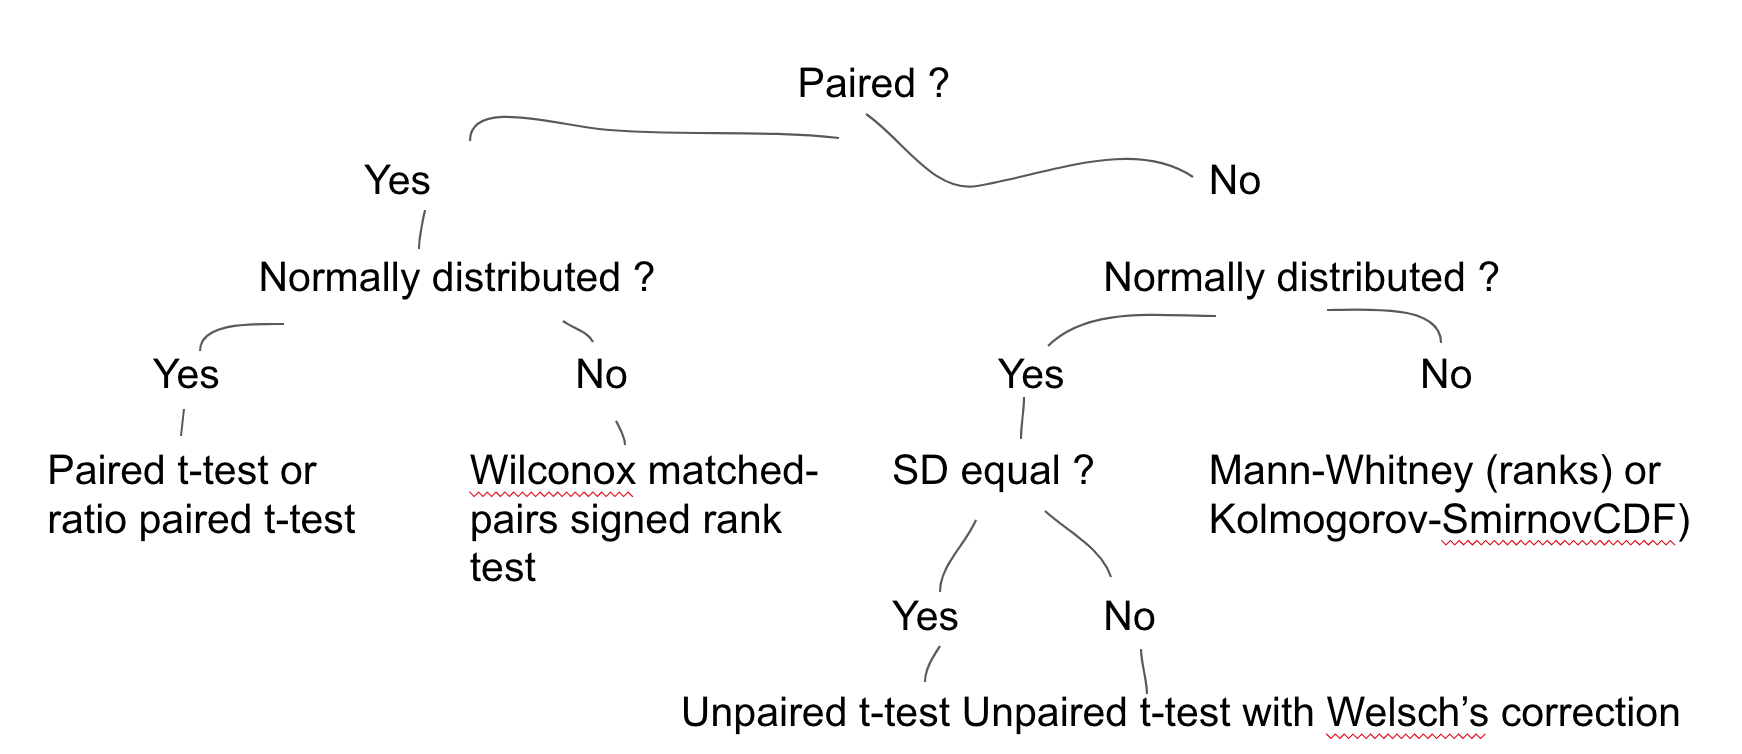


### 4.4.1 Unpaired t test for normally distributed data with not assuming equal variance

Let us perform a test comparing the sepal width of the setosa and the virginica species. 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

In [10]:
df_virginica=dataframe[dataframe['name'] == 'Iris-virginica']
df_virginica.head() # Just cheking that we got the right data by looking at the first five (head)

,slength,swidth,plength,pwidth,name
100,6.3,3.3,6.0,2.5,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica
102,7.1,3.0,5.9,2.1,Iris-virginica
103,6.3,2.9,5.6,1.8,Iris-virginica
104,6.5,3.0,5.8,2.2,Iris-virginica


We did test that the setosa setal width is very normal. Let us also check the virginica setal width.

In [11]:
k2, p = stats.normaltest(df_virginica['swidth']) # D Agostino-Pearson test
print("p-value = %1.2f" % p)

p-value = 0.28


This looks also very normal. How likely is it that these two samples come from a normal sample with the same mean?

In [12]:
stats.ttest_ind(df_setosa['swidth'],df_virginica['swidth'], equal_var = False) # False means we don't assume equal variances (Welsch's t-test)

Ttest_indResult(statistic=6.289384996672061, pvalue=9.58603917037916e-09)

**Interpretation :** It is extremly unlikely that these samples would come from a population with the same mean. 
The sample means were:

In [13]:
print("%1.2f %1.2f" % (df_virginica.mean()['swidth'], df_setosa.mean()['swidth']))

2.97 3.42


### 4.4.2 Unpaired t test for normally distributed data assuming equal variance

In [14]:
stats.ttest_ind(df_setosa['swidth'],df_virginica['swidth'], equal_var = True) # True means we assume equal variances 

Ttest_indResult(statistic=6.289384996672061, pvalue=8.916634067006443e-09)

**Interpretation :** It is extremly unlikely that these samples would come from a population with the same mean and the same variance.

The p-value got slightly worse, but such small p-values have no meaning anyway. p-values below 0.01 are often not that precise. We just know they are below 0.01.




### 4.4.3 Unpaired t test for *not* normally distributed data

Compute the Mann-Whitney rank test on samples x and y. Only use with more than 20 data points.
http://localhost:8888/notebooks/work/SDA-4-Hypothesis-Testing.ipynb#t-Test

In [15]:
stats.mannwhitneyu(df_setosa['swidth'],df_virginica['swidth'])

MannwhitneyuResult(statistic=426.5, pvalue=5.904384107706829e-09)

Let us do this test with samples from the same population.

In [16]:
print(stats.mannwhitneyu(df_setosa['swidth'][:25],df_setosa['swidth'][25:50]))
print(stats.mannwhitneyu(df_setosa['swidth'][:10],df_setosa['swidth'][40:50]))
print(stats.mannwhitneyu(df_setosa['swidth'][:5],df_setosa['swidth'][45:50]))

MannwhitneyuResult(statistic=260.0, pvalue=0.1550563944967709)
MannwhitneyuResult(statistic=42.5, pvalue=0.297517575814569)
MannwhitneyuResult(statistic=9.0, pvalue=0.2641796636354743)


The p-value varies quite a lot with the size of the samples. Here we would need to study where it gets stable.

Compute the **Kolmogorov-Smirnov** statistic on 2 samples. This is a test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp

In [17]:
stats.ks_2samp(df_setosa['swidth'],df_virginica['swidth'])

Ks_2sampResult(statistic=0.5, pvalue=3.6276162006545173e-06)

**Interpretation:** It is very unlikely that these sets come from the same population.

Let's do it on the same population.

In [18]:
print(stats.ks_2samp(df_setosa['swidth'][:25],df_setosa['swidth'][25:50]))
print(stats.ks_2samp(df_setosa['swidth'][:10],df_setosa['swidth'][40:50]))
print(stats.ks_2samp(df_setosa['swidth'][:5],df_setosa['swidth'][45:50]))

Ks_2sampResult(statistic=0.20000000000000007, pvalue=0.6485239915518617)
Ks_2sampResult(statistic=0.20000000000000007, pvalue=0.9747892465409951)
Ks_2sampResult(statistic=0.4, pvalue=0.6974048780205908)


For both tests we get very small p-values as expected, when the sets are from different species. When we split one of the datasets into two subsets, the p-values are higher. 

### 4.4.4 Paired t test for normally distributed data


Calculate the T-test on TWO RELATED samples. This is a test for the null hypothesis that 2 related or repeated samples have identical average (expected) values.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel

Let's test if the swidth and the slength (related/paired) of the setosa sample have identical means. 

In [19]:
stats.ttest_rel(df_setosa['swidth'],df_setosa['slength'])

Ttest_relResult(statistic=-42.799455674951105, pvalue=1.7724677938534975e-40)

As expected the p-value is very small (we know that swidth and slength have very different means). Let's test two subsamples from the same sample:

In [20]:
stats.ttest_rel(df_setosa.iloc[0:25,1:2],df_setosa.iloc[25:50,1:2])


Ttest_relResult(statistic=array([1.08300729]), pvalue=array([0.2895664]))

As expected the p-value is high.

### 4.4.4 Paired test for *not* normally distributed data

The Wilcoxon signed-rank test is a non-parametric statistical hypothesis test used to compare two related samples, matched samples, or repeated measurements on a single sample to assess whether their population mean ranks differ (i.e. it is a paired difference test). It can be used as an alternative to the paired Student's t-test, t-test for matched pairs, or the t-test for dependent samples when the population cannot be assumed to be normally distributed.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon

In [21]:
# If you like, make your own example.

## 4.5 ANOVA tests (analysis of variance)

Python stats module provides a one-way Anova test. The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean (a generalisation of the t-test to more than two samples). The test is applied to samples from two or more groups, possibly with differing sizes. 

Please read the documentation about assumptions before using it: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html#scipy.stats.f_oneway

In [22]:
f, p_value = stats.f_oneway(df_setosa['swidth'][0:10],df_setosa['swidth'][10:20],df_setosa['swidth'][20:30])
p_value

0.07117940263843624

In [23]:
f, p_value = stats.f_oneway(df_setosa['swidth'],df_virginica['swidth'])
p_value

8.916634067006418e-09

In last example on assumption is not fulfilled. 

### Beyond one-way ANOVA

There are examples and code for two-way, three-way and four-way etc ANOVA out there. We don't have the time to discuss them to practise them today. You can do this example if you like (maybe with Iris data):

http://www.pybloggers.com/2016/03/three-ways-to-do-a-two-way-anova-with-python/

In [24]:
from statsmodels.stats.anova import anova_lm

## 4.5 Final important words 

If you are in doubt about your results because you think you have too little data or strangely distributed data you should/could:

- Check by using another tool and see if there are changes in the results
- Manipulate your (test) data (by adding/changing artifical datapoints etc) and study the effect on the result

In the end you should enable people to interprete your results in a correct way and come to the same conclusions as you. So your results should be reproducible within the uncertainties you state.